In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
from sklearn.impute import KNNImputer # 교수님이 median, mean같은 단순 imputation은 피하라고 했음
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [3]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize

In [4]:
from sklearn.metrics import roc_auc_score, plot_roc_curve, precision_score , roc_curve , auc

In [5]:
data=pd.read_csv('healthcare-dataset-stroke-data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 1) NA imputation & Oversampling(SMOTE)

### KNN impuatation 방법
bmi에 있는 na 먼저 처리하자. MAR로 가정하자.

In [6]:
imputer = KNNImputer(n_neighbors=2)

# Selecting numerical columns for imputing missing bmi values
df_num = data.select_dtypes(exclude=['object'])
array_ = imputer.fit_transform(df_num)

# adding the column names back
colx = df_num.columns
df_num_nn = pd.DataFrame(array_, columns=colx)

df_obj = data.select_dtypes(exclude=['int64','float64'])

# concatenating the imputed numeric and object columns 
data = pd.concat([df_obj,df_num_nn], axis=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   ever_married       5110 non-null   object 
 2   work_type          5110 non-null   object 
 3   Residence_type     5110 non-null   object 
 4   smoking_status     5110 non-null   object 
 5   id                 5110 non-null   float64
 6   age                5110 non-null   float64
 7   hypertension       5110 non-null   float64
 8   heart_disease      5110 non-null   float64
 9   avg_glucose_level  5110 non-null   float64
 10  bmi                5110 non-null   float64
 11  stroke             5110 non-null   float64
dtypes: float64(7), object(5)
memory usage: 479.2+ KB


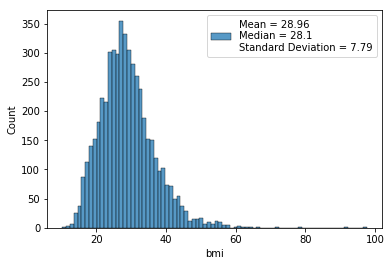

In [8]:
label_bmi='Mean = {}\nMedian = {}\nStandard Deviation = {}'.format("%.2f"%data["bmi"].mean(),data["bmi"].median(), "%.2f"%data["bmi"].std())
sns.histplot(x=data["bmi"],label=label_bmi).legend(loc='best',fontsize=10)

In [9]:
data= data.drop(['id'], axis=1)
data["Residence_type"] = data["Residence_type"].apply(lambda x: 1 if x == "Urban" else 0)
data["ever_married"] = data["ever_married"].apply(lambda x: 1 if x == "Yes" else 0)
data["gender"] = data["gender"].apply(lambda x: 1 if x == "Male" else 0)
data = pd.get_dummies(data=data, columns=['smoking_status', 'work_type'], drop_first=True) # 다중 공선성 문제

In [10]:
data.columns

Index(['gender', 'ever_married', 'Residence_type', 'age', 'hypertension',
       'heart_disease', 'avg_glucose_level', 'bmi', 'stroke',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children'],
      dtype='object')

In [11]:
X = data.drop(columns='stroke')
y = data[['stroke']]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=data.stroke, 
                                                    shuffle=True, random_state=2021)

In [13]:
y_test[y_test==1].sum()/len(y_test)
# 비율을 지키면서 잘 되어땅. 

stroke    0.048513
dtype: float64

In [14]:
samp = SMOTE()
X,y = samp.fit_resample(X_train,y_train)
y.value_counts()

stroke
1.0       3645
0.0       3645
dtype: int64

In [15]:
df2 = pd.concat([X,y], axis=1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7290 entries, 0 to 7289
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          7290 non-null   int64  
 1   ever_married                    7290 non-null   int64  
 2   Residence_type                  7290 non-null   int64  
 3   age                             7290 non-null   float64
 4   hypertension                    7290 non-null   float64
 5   heart_disease                   7290 non-null   float64
 6   avg_glucose_level               7290 non-null   float64
 7   bmi                             7290 non-null   float64
 8   smoking_status_formerly smoked  7290 non-null   uint8  
 9   smoking_status_never smoked     7290 non-null   uint8  
 10  smoking_status_smokes           7290 non-null   uint8  
 11  work_type_Never_worked          7290 non-null   uint8  
 12  work_type_Private               72

In [16]:
X_train = df2.drop(columns='stroke')
y_train = df2.stroke

## 2) Modeling


Precision은 정밀도로, True로 분류된 것 중 실제 True의 비율이다. TP/(TP+FP)

Recall은 재현율로, 실제 True 중 모델이 True로 분류한 것의 비율이다. TP/(TP+FN)

Accuracy는 정확도로, True를 True로 False를 False로 옳게 예측한 경우를 둘다 고려하는 지표이다. (TP+TN)/(TP+TN+FP+FN) 

### 뇌졸중 예측의 경우 FN(False Negative)가 치명적이다. 즉 뇌졸중에 걸린 케이스인데 아니라고 예측하는 것이 더 문제이다. 따라서 precision보다 recall을 우선시해야 한다. 

### AdaBoostClassifier

In [18]:
abc = AdaBoostClassifier(random_state=2021).fit(X_train, y_train)
abc_pred = abc.predict(X_test)

In [19]:
accuracy = accuracy_score(y_test, abc_pred)
precision = precision_score(y_test,abc_pred)
recall = recall_score(y_test,abc_pred)
f1 = f1_score(y_test,abc_pred)

print(confusion_matrix(y_test,abc_pred))
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ",f1)

print(classification_report(y_test,abc_pred,target_names=['not 1','1']))

[[1092  124]
 [  41   21]]
Accuracy:  0.8708920187793427
Precision:  0.14482758620689656
Recall:  0.3387096774193548
F1:  0.2028985507246377
              precision    recall  f1-score   support

       not 1       0.96      0.90      0.93      1216
           1       0.14      0.34      0.20        62

    accuracy                           0.87      1278
   macro avg       0.55      0.62      0.57      1278
weighted avg       0.92      0.87      0.89      1278



In [20]:
abc_pred[abc_pred==1].sum()/len(abc_pred)

0.1134585289514867

세로 쪽이 real, 가로 쪽이 예측

### RandomForestClassifier

In [21]:
rf = RandomForestClassifier(random_state=2021).fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [22]:
accuracy = accuracy_score(y_test, rf_pred)
precision = precision_score(y_test,rf_pred)
recall = recall_score(y_test,rf_pred)
f1 = f1_score(y_test,rf_pred)

print(confusion_matrix(y_test,rf_pred))
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ",f1)

print(classification_report(y_test,rf_pred,target_names=['not 1','1']))

[[1167   49]
 [  53    9]]
Accuracy:  0.92018779342723
Precision:  0.15517241379310345
Recall:  0.14516129032258066
F1:  0.15000000000000002
              precision    recall  f1-score   support

       not 1       0.96      0.96      0.96      1216
           1       0.16      0.15      0.15        62

    accuracy                           0.92      1278
   macro avg       0.56      0.55      0.55      1278
weighted avg       0.92      0.92      0.92      1278



## GradientBoostingClassifier

In [23]:
gb = GradientBoostingClassifier(random_state=2021).fit(X_train, y_train)
gb_pred = gb.predict(X_test)

In [24]:
accuracy = accuracy_score(y_test, gb_pred)
precision = precision_score(y_test,gb_pred)
recall = recall_score(y_test,gb_pred)
f1 = f1_score(y_test,gb_pred)

print(confusion_matrix(y_test,gb_pred))
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ",f1)

print(classification_report(y_test,gb_pred,target_names=['not 1','1']))

[[1125   91]
 [  45   17]]
Accuracy:  0.8935837245696401
Precision:  0.1574074074074074
Recall:  0.27419354838709675
F1:  0.19999999999999998
              precision    recall  f1-score   support

       not 1       0.96      0.93      0.94      1216
           1       0.16      0.27      0.20        62

    accuracy                           0.89      1278
   macro avg       0.56      0.60      0.57      1278
weighted avg       0.92      0.89      0.91      1278



## XGBClassifier

In [25]:
import xgboost as xg
xgb=xg.XGBClassifier(random_state=2021).fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

C:\Users\dbdms\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\dbdms\Anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\dbdms\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [26]:
accuracy = accuracy_score(y_test, xgb_pred)
precision = precision_score(y_test,xgb_pred)
recall = recall_score(y_test,xgb_pred)
f1 = f1_score(y_test,xgb_pred)

print(confusion_matrix(y_test,xgb_pred))
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ",f1)

print(classification_report(y_test,xgb_pred,target_names=['not 1','1']))

[[1168   48]
 [  52   10]]
Accuracy:  0.9217527386541471
Precision:  0.1724137931034483
Recall:  0.16129032258064516
F1:  0.16666666666666669
              precision    recall  f1-score   support

       not 1       0.96      0.96      0.96      1216
           1       0.17      0.16      0.17        62

    accuracy                           0.92      1278
   macro avg       0.56      0.56      0.56      1278
weighted avg       0.92      0.92      0.92      1278



### Adaboost만 hyperparameter tuning 진행

In [27]:
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import KFold
#crossvalidation=KFold(n_splits=5,shuffle=True,random_state=2021)

In [28]:
#ada=AdaBoostClassifier(random_state=2021)
#search_grid={'n_estimators':[100, 500, 700],'learning_rate':[0.1, 0.5, 1]}
#search=GridSearchCV(estimator=ada,param_grid=search_grid,scoring='recall',n_jobs=1,cv=crossvalidation)

In [29]:
#search.fit(X_train,y_train)
#print(search.best_params_)
#print(search.best_score_)

### 그리드 서치... 별로다

In [30]:
best = AdaBoostClassifier(learning_rate=0.1, n_estimators=95, random_state=2021).fit(X_train, y_train)
best_pred = best.predict(X_test)

In [31]:
accuracy = accuracy_score(y_test, best_pred)
precision = precision_score(y_test,best_pred)
recall = recall_score(y_test,best_pred)
f1 = f1_score(y_test,best_pred)
print(confusion_matrix(y_test,best_pred))
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ",f1)
print(classification_report(y_test,best_pred,target_names=['not 1','1']))

[[1003  213]
 [  26   36]]
Accuracy:  0.8129890453834115
Precision:  0.14457831325301204
Recall:  0.5806451612903226
F1:  0.2315112540192926
              precision    recall  f1-score   support

       not 1       0.97      0.82      0.89      1216
           1       0.14      0.58      0.23        62

    accuracy                           0.81      1278
   macro avg       0.56      0.70      0.56      1278
weighted avg       0.93      0.81      0.86      1278



f1이 가장 높은 건 러닝 0.1 n estimator 95

In [32]:
best2 = AdaBoostClassifier(algorithm='SAMME', learning_rate=0.1, n_estimators=95, random_state=2021).fit(X_train, y_train)
best2_pred = best2.predict(X_test)

In [33]:
print(confusion_matrix(y_test,best2_pred))
print(classification_report(y_test,best2_pred,target_names=['not 1','1']))

[[774 442]
 [  3  59]]
              precision    recall  f1-score   support

       not 1       1.00      0.64      0.78      1216
           1       0.12      0.95      0.21        62

    accuracy                           0.65      1278
   macro avg       0.56      0.79      0.49      1278
weighted avg       0.95      0.65      0.75      1278



### RandomForest 진행

In [34]:
rf2 = RandomForestClassifier(n_estimators=100, max_depth=2, min_samples_split=2, random_state=2021).fit(X_train, y_train)
rf2_pred = rf2.predict(X_test)

In [35]:
print(confusion_matrix(y_test,rf2_pred))
print(classification_report(y_test,rf2_pred,target_names=['not 1','1']))

[[948 268]
 [ 17  45]]
              precision    recall  f1-score   support

       not 1       0.98      0.78      0.87      1216
           1       0.14      0.73      0.24        62

    accuracy                           0.78      1278
   macro avg       0.56      0.75      0.55      1278
weighted avg       0.94      0.78      0.84      1278



## VotingClassifier

In [36]:
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier(estimators=[('best', best),('rf2', rf2), ('best2', best2)], voting='soft').fit(X_train, y_train)
vc_pred = vc.predict(X_test)

In [37]:
accuracy = accuracy_score(y_test, vc_pred)
precision = precision_score(y_test,vc_pred)
recall = recall_score(y_test,vc_pred)
f1 = f1_score(y_test,vc_pred)

print(confusion_matrix(y_test,vc_pred))
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ",f1)

print(classification_report(y_test,vc_pred,target_names=['not 1','1']))

[[893 323]
 [ 12  50]]
Accuracy:  0.7378716744913928
Precision:  0.13404825737265416
Recall:  0.8064516129032258
F1:  0.2298850574712644
              precision    recall  f1-score   support

       not 1       0.99      0.73      0.84      1216
           1       0.13      0.81      0.23        62

    accuracy                           0.74      1278
   macro avg       0.56      0.77      0.54      1278
weighted avg       0.95      0.74      0.81      1278



## 3) 결과해석: 뇌졸중의 원인은?

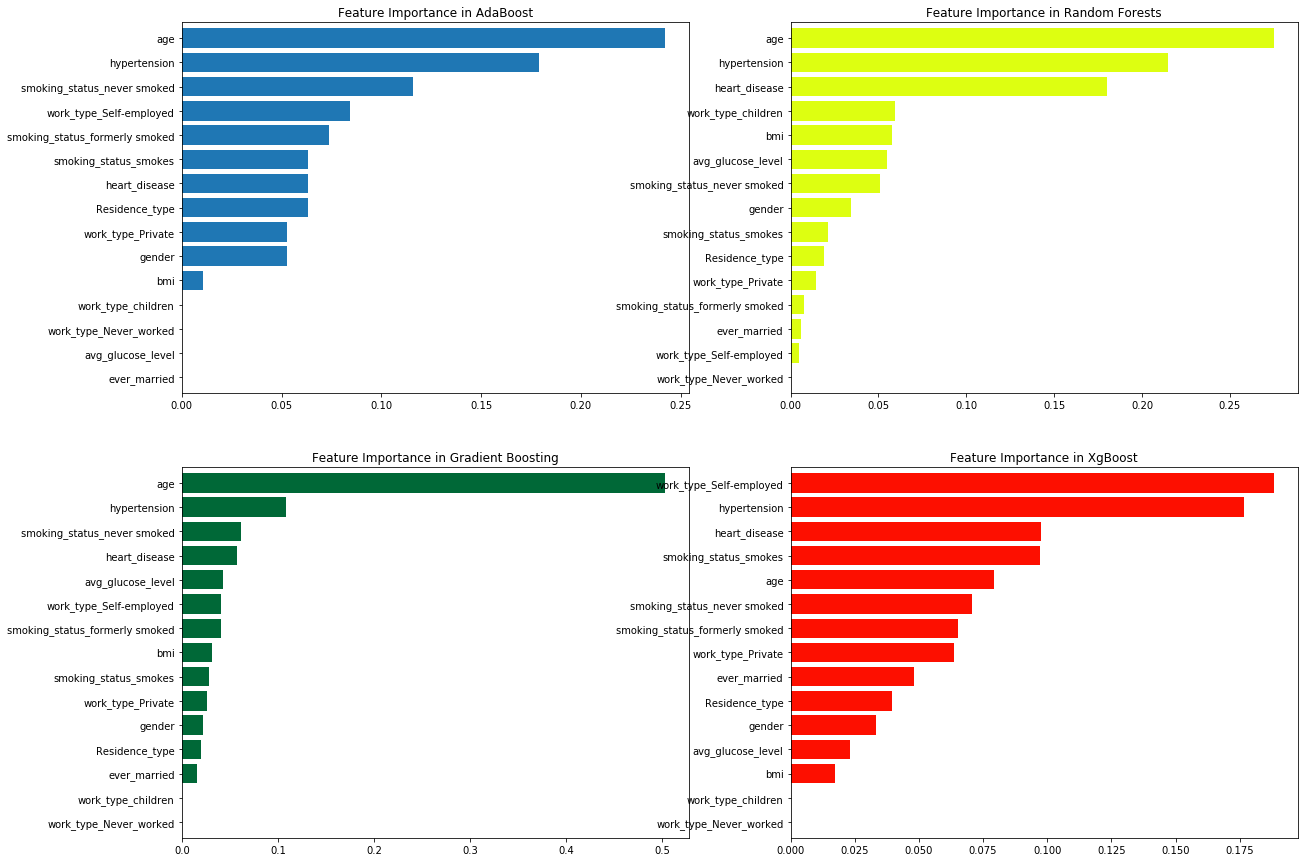

In [38]:
f,ax=plt.subplots(2,2,figsize=(20,15))

pd.Series(best.feature_importances_,X_train.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in AdaBoost')

pd.Series(rf2.feature_importances_,X_train.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,1],color='#ddff11')
ax[0,1].set_title('Feature Importance in Random Forests')

pd.Series(gb.feature_importances_,X_train.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,0],cmap='RdYlGn_r')
ax[1,0].set_title('Feature Importance in Gradient Boosting')

pd.Series(xgb.feature_importances_,X_train.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00')
ax[1,1].set_title('Feature Importance in XgBoost')
plt.show()

In [39]:
cf_matrix = confusion_matrix(y_test,rf2_pred)
print(cf_matrix)

[[948 268]
 [ 17  45]]


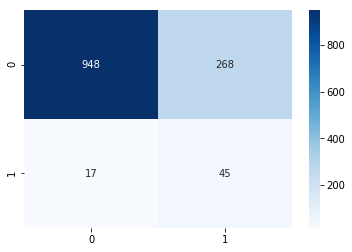

In [40]:
sns.heatmap(cf_matrix, annot=True, fmt='',cmap='Blues')

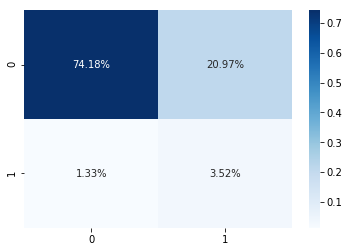

In [41]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

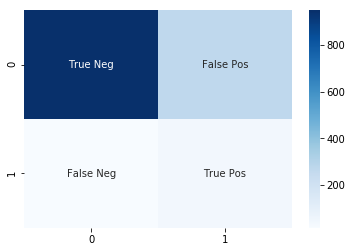

In [42]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='',cmap='Blues')

In [ ]:
feature_importance = np.array(abc.feature_importances_)
feature_names = np.array(X_train.columns)

feat_imp = pd.DataFrame({'feature_names':feature_names,
                         'feature_importance':feature_importance})

plt.figure(figsize=(8,6.4))
sns.barplot(x=feat_imp['feature_importance'],y=feat_imp['feature_names'])

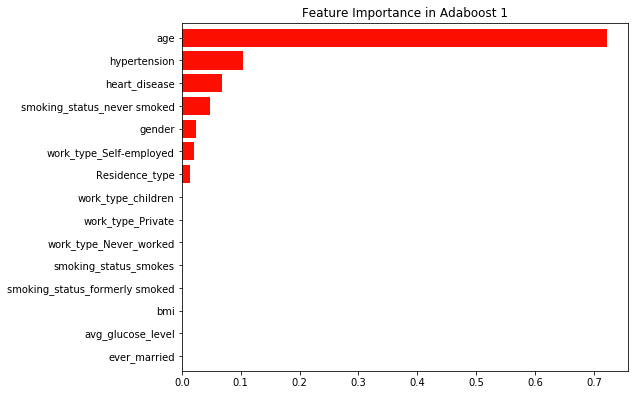

In [57]:
plt.figure(figsize=(8,6.4))
pd.Series(best2.feature_importances_,X_train.columns).sort_values(ascending=True).plot.barh(width=0.8, color='#FD0F00').set_title('Feature Importance in Adaboost 1')
plt.show()

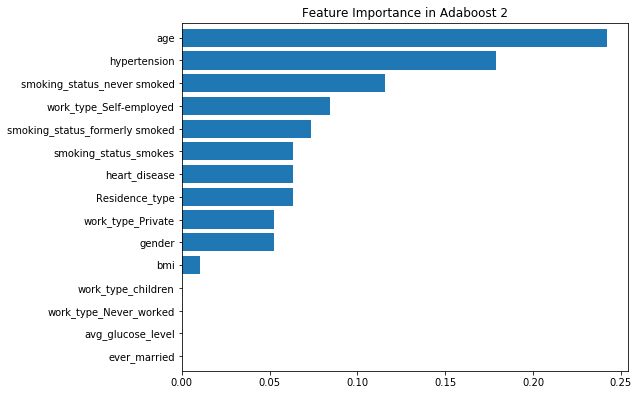

In [58]:
plt.figure(figsize=(8,6.4))
pd.Series(best.feature_importances_,X_train.columns).sort_values(ascending=True).plot.barh(width=0.8).set_title('Feature Importance in Adaboost 2')
plt.show()

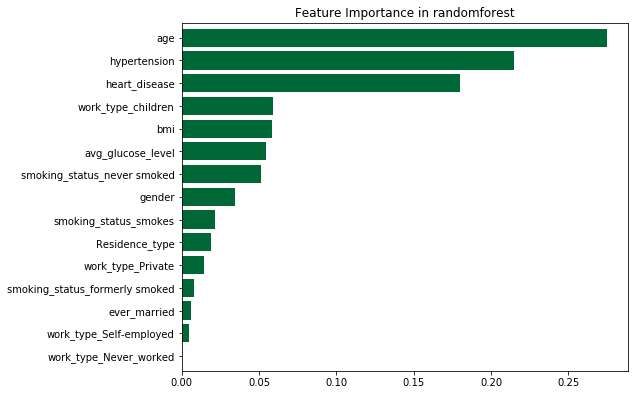

In [56]:
plt.figure(figsize=(8,6.4))
pd.Series(rf2.feature_importances_,X_train.columns).sort_values(ascending=True).plot.barh(width=0.8, cmap='RdYlGn_r').set_title('Feature Importance in randomforest')
plt.show()